In [1]:
import nsepy

In [43]:
from nsepy import get_history # to fetch the data of the stock from NSE, India 
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  # library required for scaling the data
import pandas as pd
import quandl

In [121]:
quandl.connection.ApiConfig.api_key= "_N85bWLCNCWz14smKHSi"

In [122]:
start = date(2015,1,1)
end= date.today()

In [123]:
data = quandl.get('NSE/SBIN',start_date=start,end_date=end)
#data1= quandl.get('ECB/RTD_M_S0_N_C_SP500_X', start_date=start,end_date=end)

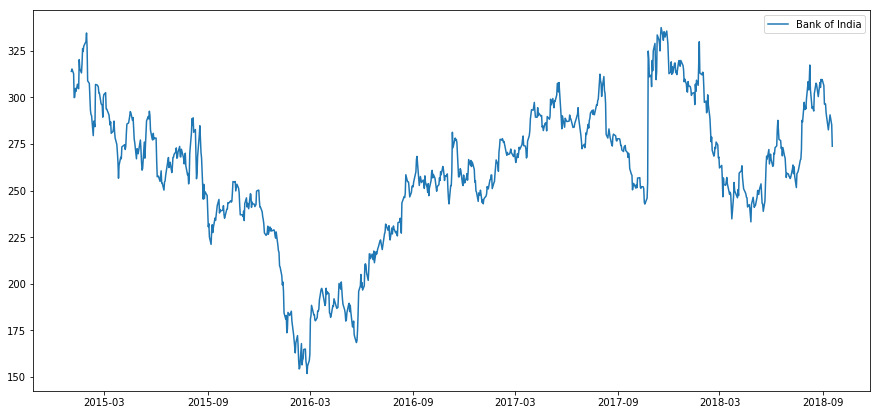

In [124]:
plt.figure(figsize=(15,7))
plt.plot(data.Close, label='Bank of India')
plt.legend()
plt.show()

In [125]:
data.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2015-01-01,312.45,315.00,310.70,314.0,314.00,6138488.0,19254.89
2015-01-02,314.35,318.30,314.35,315.6,315.25,9935094.0,31473.89
2015-01-05,316.25,316.80,312.10,312.8,312.75,9136716.0,28674.32
2015-01-06,310.00,311.10,298.70,299.9,299.90,15329257.0,46776.01
2015-01-07,300.00,302.55,295.15,301.4,300.15,15046745.0,45132.43


In [126]:
# Specify the test data size
test_size=100
# To avoid any look forward bias we will be taking only the train data to scale the data
max_=data.iloc[:-test_size][['Open','High','Low','Close']].max().max() #Using .max() once gives the maximum values of each column
min_=data.iloc[:-test_size][['Open','High','Low','Close']].min().min()
max_,min_

(351.3, 148.25)

In [127]:
X1=(data[['Open','High','Low','Close']]-min_)/(max_-min_)
X1=np.array(X1)

In [128]:
X1[-5:]

array([[0.68505294, 0.70524501, 0.65698104, 0.66165969],
       [0.66855454, 0.68185176, 0.64885496, 0.67495691],
       [0.6985964 , 0.70696873, 0.69170155, 0.7013051 ],
       [0.69071657, 0.69071657, 0.66904703, 0.67495691],
       [0.67347944, 0.68283674, 0.61142576, 0.61832061]])

In [129]:
# Here we will instantiate a Minmaxscaler function 
# Then fit the Volume column data and transform it to the range of 0,1.
# Here we specify the shape of input as it is a single column, and sklearn expexcts you to explicyt 
# reshape when input data is a single column
scl=MinMaxScaler()
scl.fit(data[['Total Trade Quantity']].iloc[:-test_size].values.reshape(-1,1))
X2=scl.transform(data[['Total Trade Quantity']].values.reshape(-1,1))

In [130]:
data=data.assign(Open=X1[:,0])
data=data.assign(High=X1[:,1])
data=data.assign(Low=X1[:,2])
data=data.assign(Close=X1[:,3])
data=data.assign(Volume=X2[:,0])
data.tail()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),Volume
Date,,,,,,,,
2018-09-11,0.685053,0.705245,0.656981,282.00,0.661660,28361400.0,81437.74,0.100914
2018-09-12,0.668555,0.681852,0.648855,285.85,0.674957,22717796.0,64431.65,0.079259
2018-09-14,0.698596,0.706969,0.691702,290.65,0.701305,15149585.0,43978.39,0.050219
2018-09-17,0.690717,0.690717,0.669047,285.10,0.674957,16089996.0,45974.26,0.053828
2018-09-18,0.673479,0.682837,0.611426,273.60,0.618321,33901000.0,94012.20,0.122170


### <span style="color:brown">Creating feature and target datasets</span>

Now, we will create prediction data 'Y' and split test/training sets. 

The steps are: 

- Step 1: Create a feature data set (OHLCV) called <font color =red>X</font> which will be used to create the input for the DNN model
- Step 2: Create a dataset called <font color =red>y</font> that contains the future price trend
- Step 3: Split the dataset so that the last 100 rows are test data.


In [131]:
# Step 1: Creation of Dataset X
X=data[['Open','High','Low','Close','Volume']]

In [132]:
# Step 2: Creation of Dataset y
# Here we first create a column of ones that has the same length as the dataframe 'data'.
# Later we will store the target values in this column.
# We have given the target of predicting the weekly returns' trend to our strategy.
# So the target variable will attempt to predict if the close price has increased or decreased after 5 trading days.
y=np.ones(len(data.Close))
y=np.where(data.Close.shift(-5)>data.Close,1,0) # If the returns are higher, then 'y' is 1, else '0'.

In [133]:
# Step 3: Creation of 4 Datasets
X_train=np.array(X.iloc[:-test_size])
y_train=np.array(y[:-test_size])
X_test=np.array(X.iloc[-test_size:])
y_test=np.array(y[-test_size:])

### <span style="color:brown">Set Class Weights</span>

The steps are:
- Calculate the number of instances of each class (#s of '0's and '1's)
- Calculate the percentage distribution of each class in the train data (% of '0's and '1's)
- Allocate the percentage distribution of class 0 to class 1 and vice versa (this is explained in a previous video)

This allows the model to pick data of both the classes or cases, when the output(y) is '0' or '1', with equal probabilitiy. Hence, the model should learn well. 

In [134]:
class_1=y_train.sum()
class_0=len(y_train)-class_1

class_1,class_0

(397, 424)

In [135]:
class_0_percentage=class_0/len(y_train)
class_1_percentage=class_1/len(y_train)

class_0_weight=class_1_percentage
class_1_weight=class_0_percentage

# We will create a dictionary called class_weight to allocate the corresponding weghts to each of the labels.
class_weight={0:class_0_weight,1:class_1_weight}

In [136]:
class_weight

{0: 0.4835566382460414, 1: 0.5164433617539586}

In [137]:
# Libraries
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Activation
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization

In [138]:
# Parameters - please tweak them in later runs
dropout_ratio=0.23
momentum=0.99
np.random.seed(42)
neurons=175
act_1='tanh'
act_2='softmax'

*model.add(Dense(neurons, use_bias=True, kernel_initializer='he_normal',bias_initializer='zeros',input_shape=X_train.shape[1:]))*

- Dense: to define a dense layer
- neurons: to define the number of neurons (this keeps on increasing in every layer)
- use_bias=True: it keeps the bias term in the equation
- kernel_initializer='he_normal': at the first run, use weights from He-normal distribution
- bias_initializer='zeros': at the first run, use bias as '0'
- input_shape=X_train.shape[1:])): to define the number of columns or features that go as input in the first run


In [139]:
X_train.shape[1:], X_train.shape

((5,), (821, 5))

In [140]:
# The DNN Model

model=Sequential() #We want the layers to work sequentially, one after other.

#glorot_uniform Glorot uniform initializer, also called Xavier uniform initializer.

# Layer 1
model.add(Dense(neurons, use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros',input_shape=X_train.shape[1:]))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))

# Layer 2
model.add(Dense(neurons*2, use_bias=True, kernel_initializer='glorot_uniform'
               , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))

# Layer 3
model.add(Dense(neurons*3, use_bias=True, kernel_initializer='glorot_uniform'
               , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))

# Layer 4
model.add(Dense(neurons*4, use_bias=True, kernel_initializer='glorot_uniform'
              , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))

# Layer 5
model.add(Dense(neurons*5, use_bias=True, kernel_initializer='glorot_uniform'
              , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))

model.add(Dense(1,activation='sigmoid')) # Layer 6

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

### <span style="color:brown">Define and save the monitoring parameter</span>

In Keras, we can save the best weights of the model by creating a checkpoint during the training of the model. To create a checkpoint, we specify the metric that needs to be monitored and saved accordingly.  

<span style="color:#ac6600">Validation set loss</span> is passed as the monitoring parameter. The mode of saving is specified as 'auto'. This means that the model will save the weights of the network whenever a low value for the validation loss is generated. 

The file path is weights-best2.hdf5 to save the weights of the model.

The verbose=1 parameter defines how much information about every batch training needs to be printed.

In [141]:
filepath="weights-best2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [142]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 175)               1050      
_________________________________________________________________
activation_11 (Activation)   (None, 175)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 175)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 350)               61600     
_________________________________________________________________
activation_12 (Activation)   (None, 350)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 350)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 525)               184275    
__________

In [143]:
training=model.fit(X_train, y_train, epochs=250, batch_size=256, verbose=1, validation_split=0.2,
                   callbacks=[checkpoint],class_weight=class_weight)

Train on 656 samples, validate on 165 samples
Epoch 1/250
656/656 [==============================] - 1s 1ms/step - loss: 0.4029 - acc: 0.5076 - val_loss: 0.4379 - val_acc: 0.3697

Epoch 00001: val_loss improved from inf to 0.43794, saving model to weights-best2.hdf5
Epoch 2/250
656/656 [==============================] - 0s 250us/step - loss: 0.3698 - acc: 0.4954 - val_loss: 0.3319 - val_acc: 0.6303

Epoch 00002: val_loss improved from 0.43794 to 0.33187, saving model to weights-best2.hdf5
Epoch 3/250
656/656 [==============================] - 0s 265us/step - loss: 0.3509 - acc: 0.5183 - val_loss: 0.4192 - val_acc: 0.3697

Epoch 00003: val_loss did not improve from 0.33187
Epoch 4/250
656/656 [==============================] - 0s 238us/step - loss: 0.3559 - acc: 0.5259 - val_loss: 0.3320 - val_acc: 0.6303

Epoch 00004: val_loss did not improve from 0.33187
Epoch 5/250
656/656 [==============================] - 0s 235us/step - loss: 0.3593 - acc: 0.4924 - val_loss: 0.3422 - val_acc: 0.67

656/656 [==============================] - 0s 238us/step - loss: 0.3549 - acc: 0.4970 - val_loss: 0.3632 - val_acc: 0.3758

Epoch 00044: val_loss did not improve from 0.33187
Epoch 45/250
656/656 [==============================] - 0s 211us/step - loss: 0.3570 - acc: 0.4954 - val_loss: 0.3434 - val_acc: 0.4303

Epoch 00045: val_loss did not improve from 0.33187
Epoch 46/250
656/656 [==============================] - 0s 230us/step - loss: 0.3456 - acc: 0.5534 - val_loss: 0.3351 - val_acc: 0.6303

Epoch 00046: val_loss did not improve from 0.33187
Epoch 47/250
656/656 [==============================] - 0s 228us/step - loss: 0.3452 - acc: 0.5442 - val_loss: 0.3523 - val_acc: 0.3818

Epoch 00047: val_loss did not improve from 0.33187
Epoch 48/250
656/656 [==============================] - 0s 243us/step - loss: 0.3485 - acc: 0.5152 - val_loss: 0.3637 - val_acc: 0.3697

Epoch 00048: val_loss did not improve from 0.33187
Epoch 49/250
656/656 [==============================] - 0s 231us/step - l


Epoch 00087: val_loss did not improve from 0.33187
Epoch 88/250
656/656 [==============================] - 0s 229us/step - loss: 0.3432 - acc: 0.5488 - val_loss: 0.3416 - val_acc: 0.5030

Epoch 00088: val_loss did not improve from 0.33187
Epoch 89/250
656/656 [==============================] - 0s 209us/step - loss: 0.3425 - acc: 0.5640 - val_loss: 0.3449 - val_acc: 0.4545

Epoch 00089: val_loss did not improve from 0.33187
Epoch 90/250
656/656 [==============================] - 0s 229us/step - loss: 0.3442 - acc: 0.5473 - val_loss: 0.3439 - val_acc: 0.4545

Epoch 00090: val_loss did not improve from 0.33187
Epoch 91/250
656/656 [==============================] - 0s 230us/step - loss: 0.3438 - acc: 0.5564 - val_loss: 0.3405 - val_acc: 0.5818

Epoch 00091: val_loss did not improve from 0.33187
Epoch 92/250
656/656 [==============================] - 0s 253us/step - loss: 0.3427 - acc: 0.5595 - val_loss: 0.3433 - val_acc: 0.4606

Epoch 00092: val_loss did not improve from 0.33187
Epoch 93

656/656 [==============================] - 0s 232us/step - loss: 0.3459 - acc: 0.5152 - val_loss: 0.3469 - val_acc: 0.4364

Epoch 00174: val_loss did not improve from 0.33187
Epoch 175/250
656/656 [==============================] - 0s 222us/step - loss: 0.3420 - acc: 0.5701 - val_loss: 0.3387 - val_acc: 0.6606

Epoch 00175: val_loss did not improve from 0.33187
Epoch 176/250
656/656 [==============================] - 0s 233us/step - loss: 0.3450 - acc: 0.5366 - val_loss: 0.3412 - val_acc: 0.5636

Epoch 00176: val_loss did not improve from 0.33187
Epoch 177/250
656/656 [==============================] - 0s 228us/step - loss: 0.3421 - acc: 0.5686 - val_loss: 0.3408 - val_acc: 0.6121

Epoch 00177: val_loss did not improve from 0.33187
Epoch 178/250
656/656 [==============================] - 0s 225us/step - loss: 0.3434 - acc: 0.5488 - val_loss: 0.3406 - val_acc: 0.6303

Epoch 00178: val_loss did not improve from 0.33187
Epoch 179/250
656/656 [==============================] - 0s 225us/ste

In [144]:
training.history.keys()

dict_keys(['loss', 'acc', 'val_acc', 'val_loss'])

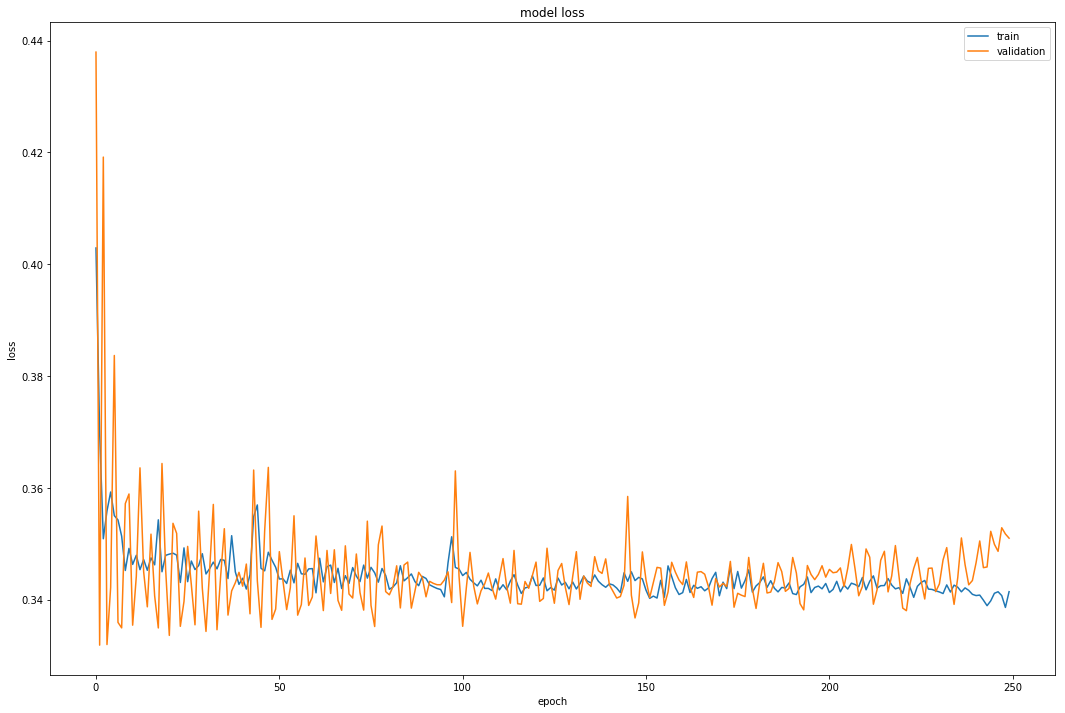

In [145]:
# summarize history for loss
plt.figure(figsize=(18,12))
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

## Predicting the Trend

Now, we will create a list called predict_close that would hold the DNN model's predicitons on the test data.

The output of the keras predict function is a probability value, where a probability of more than 0.5 means that the data belongs to class 1 and a probability of less than or equal to 0.5 means that the data belongs to class 0.

Based on these probability values, we will seperate the Buy and Sell signals for the strategy, by assuming a buy signal of +1 when the output probability is more than 0.5 and a sell signal of -1 otherwise.

In [146]:
x_=np.expand_dims(X_test[0],axis=0)
print(x_.shape)
print(model.predict(x_)[0])

(1, 5)
[0.5626913]


In [147]:
predict_trend_1=np.ones(len(X_test))
print(predict_trend_1.shape)
a=np.reshape(predict_trend_1,(1,-1)).tolist()[0]
print(a)

(100,)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [148]:
predict_trend=np.ones(len(X_test))
for i in range(X_test.shape[0]):    
    predict_trend[i]=np.where(model.predict(np.expand_dims(X_test[i],axis=0))[0][0]>0.5,1,-1)
predict_trend=np.reshape(predict_trend,(1,-1)).tolist()[0]
y_test=np.where(y_test==0,-1,1)
from sklearn.metrics import accuracy_score

acc= accuracy_score(list(y_test),list(predict_trend))

In [149]:
print("The Accuracy of the model on the test set is:",acc*100,'%')
print("\n\n\nThe Signals Predicted\n",list(predict_trend))
# he_normal The Accuracy of the model on the test set is: 64.0 %
# glorot_uniform The Accuracy of the model on the test set is: 61.0 %


The Accuracy of the model on the test set is: 61.0 %



The Signals Predicted
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


## Visualizing and comparing the performance

Now, let us plot the performance of the model on the test data by multiplying the buy and sell signals with the corresponding future returns.

Once we calculate the percentage returns of the model, we will take a cumulative sum of all these returns on the test data to measure the overall performance of the model.


We have also plotted the cumulative markets returns to compare how a simple Buy and Hold strategy would have performed in comparison to our model.

The annualized interest rate in India is currently 6%. So, for the 100-day period in the test data, the interest rate would be adjusted.

In [150]:
market_returns=pd.Series(data.Last.shift(-1).iloc[-test_size:].pct_change().values)
strategy_returns=pd.Series(predict_trend*market_returns)
intrest_rate=0.06/3

In [151]:
Sharpe=(np.nansum(strategy_returns)-intrest_rate)/strategy_returns.std()

In [152]:
Sharpe

8.079396954546178

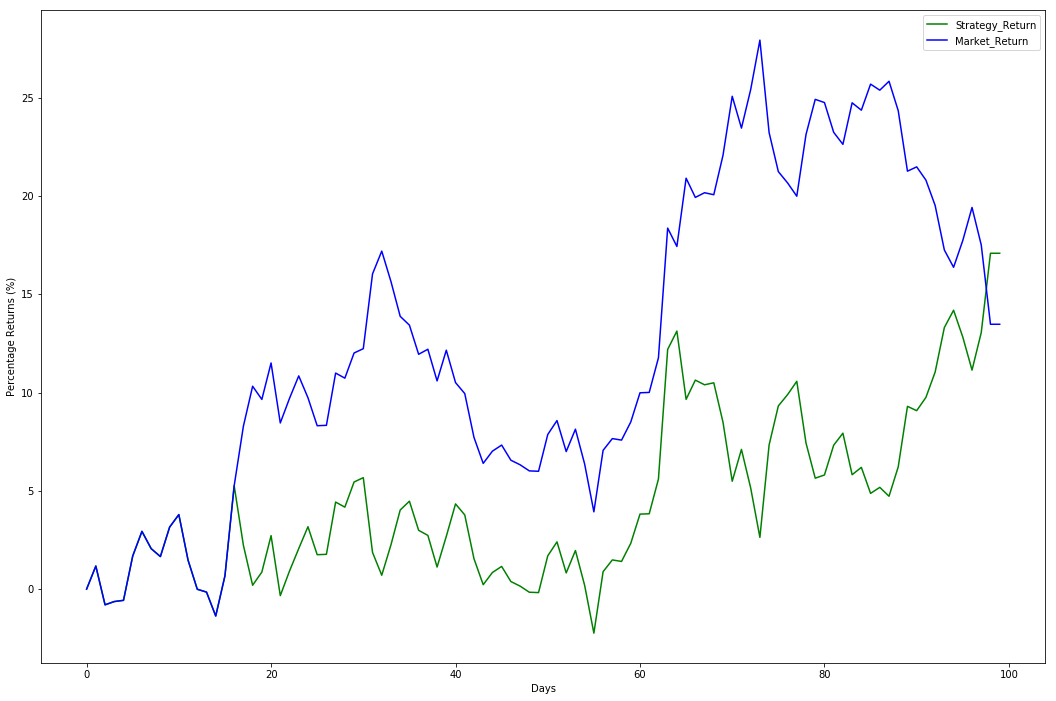

In [153]:
plt.figure(figsize=(18,12))
plt.plot(np.nancumsum(strategy_returns)*100,c='g')
plt.plot(np.nancumsum(market_returns)*100,c='b')
plt.ylabel('Percentage Returns (%)')
plt.xlabel('Days')
plt.legend(['Strategy_Return','Market_Return'])
plt.show()


In [154]:
final_return=np.nancumsum(strategy_returns)*100

In [155]:
final_return[-1]

17.084162209486962